# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

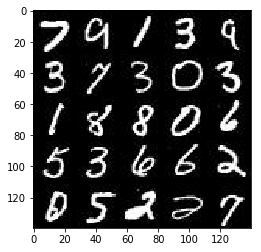

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

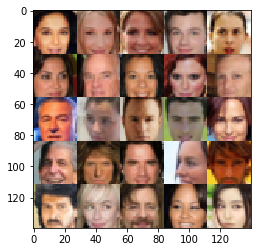

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate= tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        d1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * d1, d1)
        #16x16x64
        
        d2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        relu2 = tf.maximum(alpha * d2, d2)
        #8x8x128
        
        d3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        relu3 = tf.maximum(alpha * d3, d3)
        #4x4x256
         
        #flattening the image    
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    return logits, output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator',reuse=not is_train):
        g1 = tf.layers.dense(z, 4*4*512)
        g1 = tf.reshape(g1, (-1, 4, 4, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same')
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)

        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same')
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)
         
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(logits, [28,28])
        
        out = tf.tanh(logits) *0.5
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim)
    d_logits_real,d_out_real = discriminator(input_real)
    d_logits_fake,d_out_fake = discriminator(g_out,True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))

    d_loss = d_loss_real+d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    iterations = 0
    print_every =10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                iterations +=1
                
                if iterations % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if iterations % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 1.4381... Generator Loss: 0.5493
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.6600


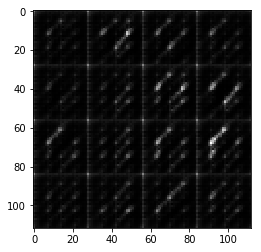

Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.7385


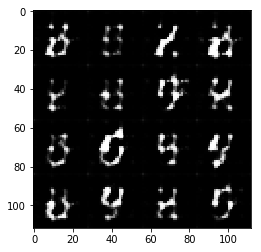

Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 0.4944
Epoch 1/2... Discriminator Loss: 1.2906... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.5653
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.7014


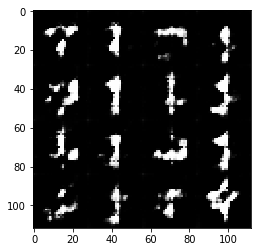

Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 0.6390
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.9188
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 0.9105
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.6126
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.3960


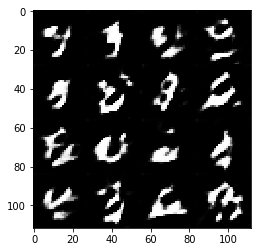

Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.6601
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.2949... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.5711
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.7062


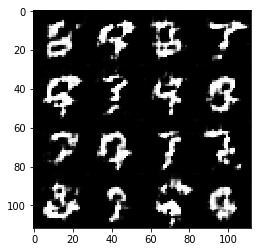

Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.7407
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.4588
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.8055


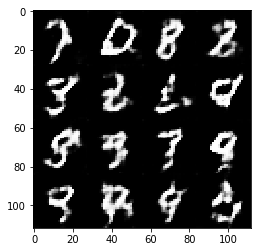

Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.3546... Generator Loss: 0.6798
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 1.3612
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.8103


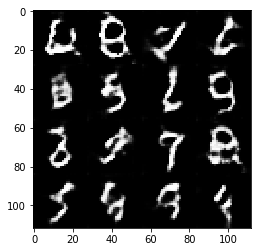

Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.8842
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.6799
Epoch 1/2... Discriminator Loss: 1.2931... Generator Loss: 0.7217


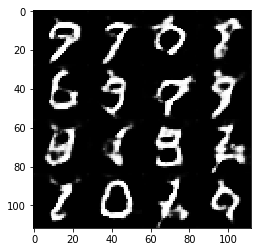

Epoch 1/2... Discriminator Loss: 1.2770... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.6463
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.6929


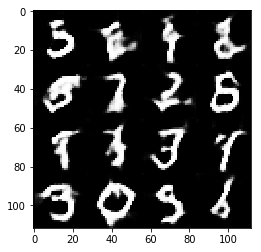

Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.8151
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.6080


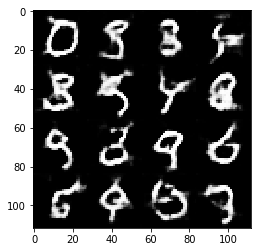

Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.8601
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.5965
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.7828
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.7209
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.7411


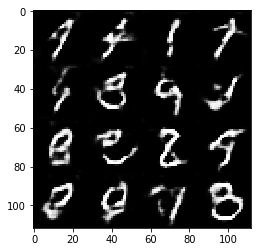

Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.7360
Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.7251
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.8276
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.5512
Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 0.7302


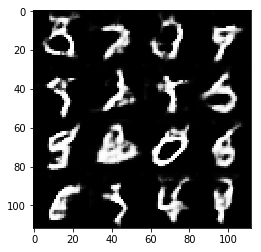

Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.5321
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 1.4627... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.4633... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.5030... Generator Loss: 0.6635


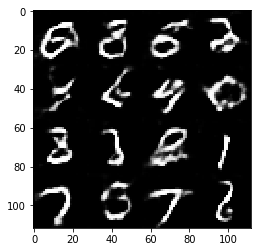

Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.3259... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.9442
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.6735


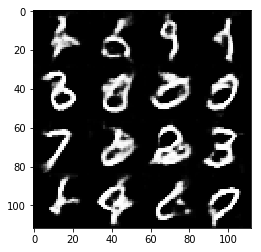

Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.7094
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.8195
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.8927
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.4180... Generator Loss: 0.6878
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.7193


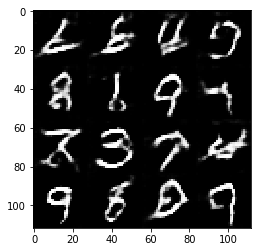

Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.7105


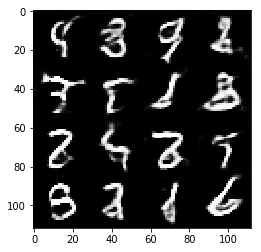

Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.6042
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.9867
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.8764


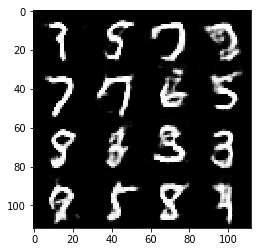

Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.8111
Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.9638
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.6892
Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.8252
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.7886


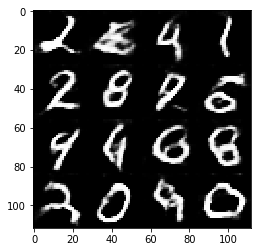

Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.8152


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6151


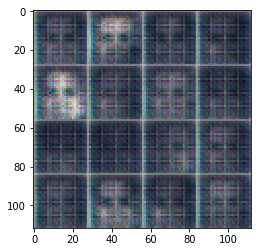

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7587


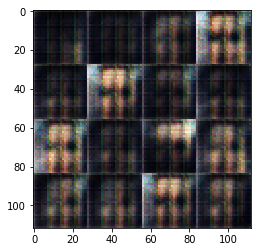

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6871


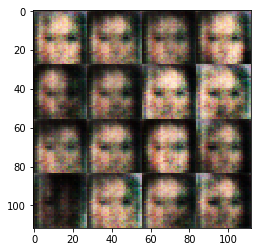

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6891


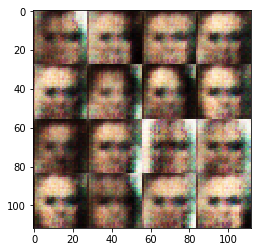

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6620


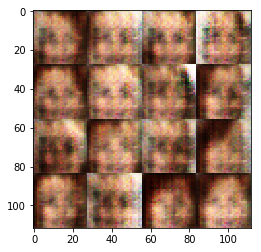

Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6543


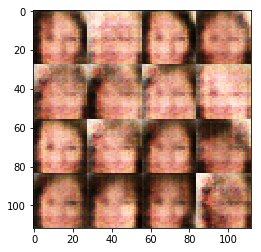

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6751


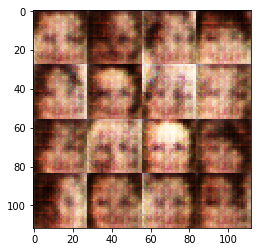

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6751


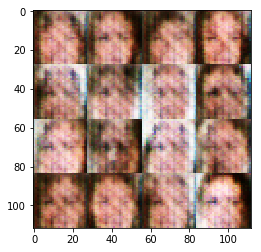

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6720


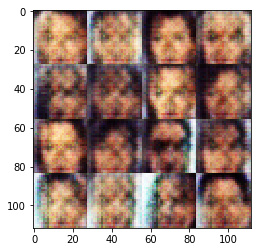

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6919


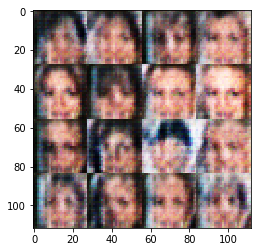

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.6767


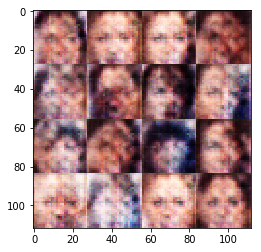

Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7659


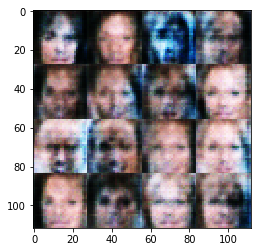

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.5994


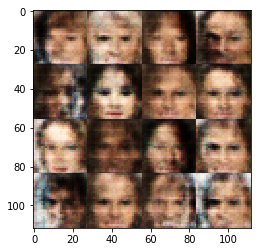

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7129


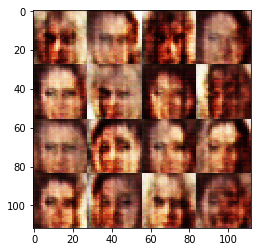

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6459


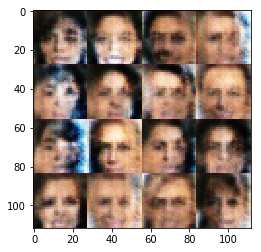

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.7352


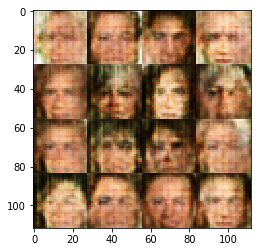

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6737


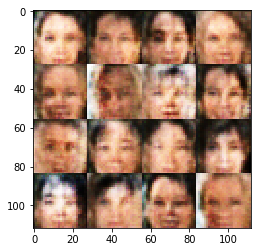

Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.6986


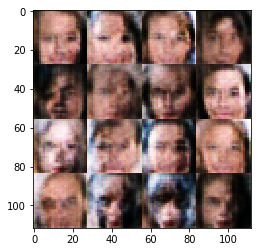

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7333


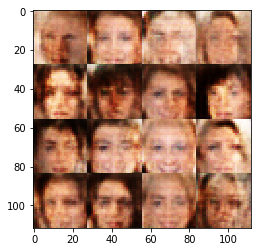

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6576


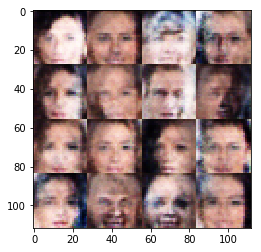

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6943


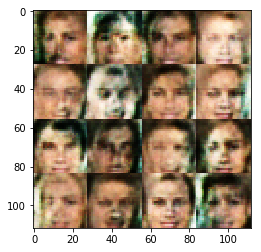

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7266


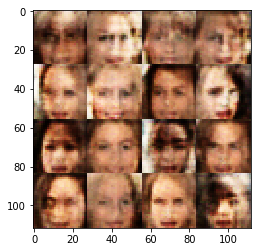

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6668


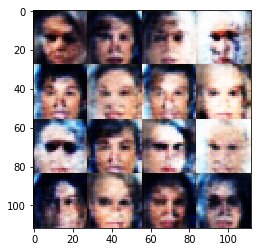

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6977


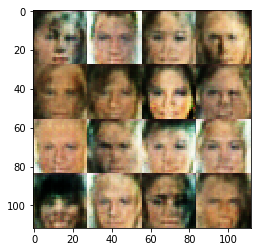

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7238


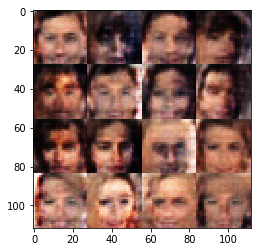

Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7210


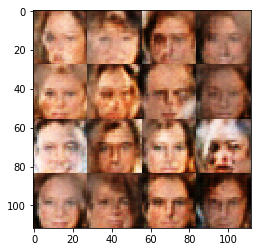

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6765


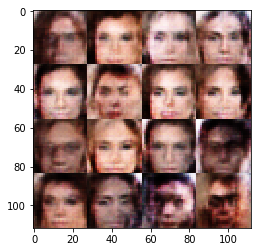

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7145


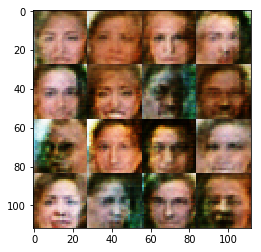

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7059


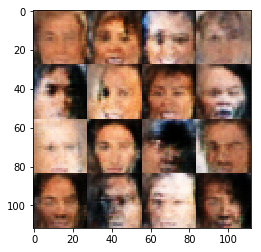

Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7384


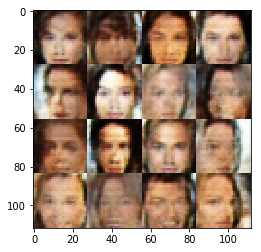

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6916


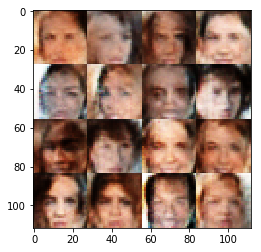

Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7252


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.